In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import statistics

# modeling
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 50)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_seq_items', 50)
pd.set_option('display.width', 100)

In [4]:
# chargement des bases de données
df_geolocation = pd.read_csv('Data/olist_geolocation_dataset.csv')
df_orders = pd.read_csv('Data/olist_orders_dataset.csv')
df_order_items = pd.read_csv('Data/olist_order_items_dataset.csv')
df_order_reviews = pd.read_csv('Data/olist_order_reviews_dataset.csv')
df_customers = pd.read_csv('Data/olist_customers_dataset.csv')
df_order_payments = pd.read_csv('Data/olist_order_payments_dataset.csv')
df_products = pd.read_csv('Data/olist_products_dataset.csv')
df_sellers = pd.read_csv('Data/olist_sellers_dataset.csv')
df_product_category_name = pd.read_csv(
    'Data/product_category_name_translation.csv')

## Fonctions

In [5]:
# Pour Calculer la distance Orthodromique
def deg2rad(x):
    return math.pi*x/180


def get_distance_m(lat1, lng1, lat2, lng2):
    earth_radius = 6378137   # Terre = sphère de 6378km de rayon
    rlo1 = deg2rad(lng1)    # CONVERSION
    rla1 = deg2rad(lat1)
    rlo2 = deg2rad(lng2)
    rla2 = deg2rad(lat2)
    dlo = (rlo2 - rlo1) / 2
    dla = (rla2 - rla1) / 2
    a = (np.sin(dla) * np.sin(dla)) + np.cos(rla1) * \
        np.cos(rla2) * (np.sin(dlo) * np.sin(dlo))
    d = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return (earth_radius * d)

In [6]:
# génération des données en fonction de la date choisi
def dataGenerate(timeDelta):
    df_orders_gen = df_orders[df_orders['order_purchase_timestamp'] < (
        df_orders['order_purchase_timestamp'].max() - pd.to_timedelta(timeDelta, unit='D'))]
    df = pd.DataFrame(
        {'customer_unique_id': df_orders_gen['customer_unique_id'].value_counts().index})
    df = df.merge(df_customers.groupby('customer_unique_id').first()[
                  'customer_city'], on='customer_unique_id')

    city_count = df['customer_city'].value_counts()
    df['customer_city_size'] = df['customer_city'].apply(
        lambda x: city_count[x])
    df['customer_city_size_log'] = np.log(df['customer_city_size'])
    df.drop(['customer_city', 'customer_city_size'], axis=1, inplace=True)

    # Merge df_orders
    order_agg = {
        'customer_id': 'count',
        'order_purchase_timestamp': 'max',
        'payment_value': 'sum'
    }
    df = df.merge(df_orders_gen.groupby('customer_unique_id').agg(
        order_agg), on='customer_unique_id')

    # Merge df_order_items
    order_items_agg = {'price': 'mean',
                       'freight_value': 'mean',
                       'orthodromique_distance_log': 'mean',
                       'product_volume_log': 'mean'
                       }
    df = df.merge(df_order_items.groupby('customer_unique_id').agg(
        order_items_agg), on='customer_unique_id')

    # fillna
    fill_dicf = {
        'orthodromique_distance_log': df['orthodromique_distance_log'].mean(),
        'product_volume_log': df['product_volume_log'].mean()
    }
    df.fillna(fill_dicf, inplace=True)

    df['order_purchase_timestamp'] = (df['order_purchase_timestamp'].max(
    ) - df['order_purchase_timestamp']).astype('timedelta64[h]')/24
    return df

## Nettoyage des données

In [7]:
# prepare customers
df_geolocation = df_geolocation.groupby(['geolocation_zip_code_prefix']).mean()
df_customers = df_customers.merge(
    df_geolocation, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')
df_customers['customer_city'] = df_customers['customer_city'].str.title()

# prépare order
df_orders = df_orders.merge(
    df_customers[['customer_unique_id', 'customer_id']], on='customer_id')
df_orders = df_orders.merge(df_order_reviews, on='order_id', how='left')

df_orders = df_orders.sort_values(by='review_answer_timestamp').drop_duplicates(
    subset=['order_id'], keep='last')

df_payment = pd.DataFrame({'order_id': df_order_payments['order_id'].value_counts(
).index, 'number_of_payment': df_order_payments['order_id'].value_counts()})
df_payment = df_payment.merge(df_order_payments[[
                              'order_id', 'payment_value']].groupby('order_id').sum(), on='order_id')
df_orders = df_orders.merge(df_payment, on='order_id')
df_orders['order_purchase_timestamp'] = pd.to_datetime(
    df_orders['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')

# prépare order items
df_sellers = df_sellers.merge(df_geolocation, left_on='seller_zip_code_prefix',
                              right_on='geolocation_zip_code_prefix', how='left')
df_order_items = df_order_items.merge(df_sellers, on='seller_id', how='left')
df_order_items = df_order_items.merge(df_products, on='product_id', how='left')
df_order_items = df_order_items.merge(
    df_orders[['order_id', 'customer_unique_id']], on='order_id')

df_order_items = df_order_items.merge(df_customers[[
                                      'customer_unique_id', 'geolocation_lat', 'geolocation_lng']], on="customer_unique_id", suffixes=('_seller', '_customer'))
df_order_items['orthodromique_distance'] = get_distance_m(
    df_order_items['geolocation_lat_seller'], df_order_items['geolocation_lng_seller'], df_order_items['geolocation_lat_customer'], df_order_items['geolocation_lng_customer'])
df_order_items['orthodromique_distance_log'] = np.log(
    df_order_items['orthodromique_distance']+1)
df_order_items['product_volume'] = df_order_items['product_height_cm'] * \
    df_order_items['product_length_cm'] * df_order_items['product_width_cm']
df_order_items['product_volume_log'] = np.log(
    df_order_items[['product_volume']]+1)

## Modeling

In [10]:
# essaye des différents intervals de temps
step_range = range(10, 300, 20)
df_step = pd.DataFrame(columns=['mean', 'perf', 'step', 'shape_first',
                       'shape_last', 'shape_last_mean'], index=step_range)

for step in tqdm(step_range):
    perf = []
    shapef = []
    shapel = []
    for intarval in range(0, 400, step):
        df_first = dataGenerate(intarval + step)
        df_last = dataGenerate(intarval)
        shapef.append(df_first.shape[0])
        shapel.append(df_last.shape[0])
        Xf = df_first.drop(
            ['customer_unique_id', 'customer_id'], axis=1).values
        Xl = df_last.drop(['customer_unique_id', 'customer_id'], axis=1).values

        # Modeling
        scalerM0 = StandardScaler()
        scalerM0.fit(Xf)
        Xf_M0 = scalerM0.transform(Xf)
        model_0 = KMeans(n_clusters=3)
        model_0.fit(Xf_M0)
        scalerM1 = StandardScaler()
        scalerM1.fit(Xl)

        Xl_M0 = scalerM0.transform(Xl)
        Xl_M1 = scalerM1.transform(Xl)
        model_1 = KMeans(n_clusters=3)
        model_1.fit(Xl_M1)
        perf.append(adjusted_rand_score(
            model_0.predict(Xl_M0), model_1.predict(Xl_M1)))
    df_step.loc[step, 'mean'] = statistics.mean(perf)
    df_step.loc[step, 'perf'] = perf
    df_step.loc[step, 'step'] = step
    df_step.loc[step, 'shape_first'] = shapef
    df_step.loc[step, 'shape_last'] = shapel
    df_step.loc[step, 'shape_last_mean'] = statistics.mean(shapel)

100%|██████████| 15/15 [06:52<00:00, 27.49s/it]


## Visualisation

(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

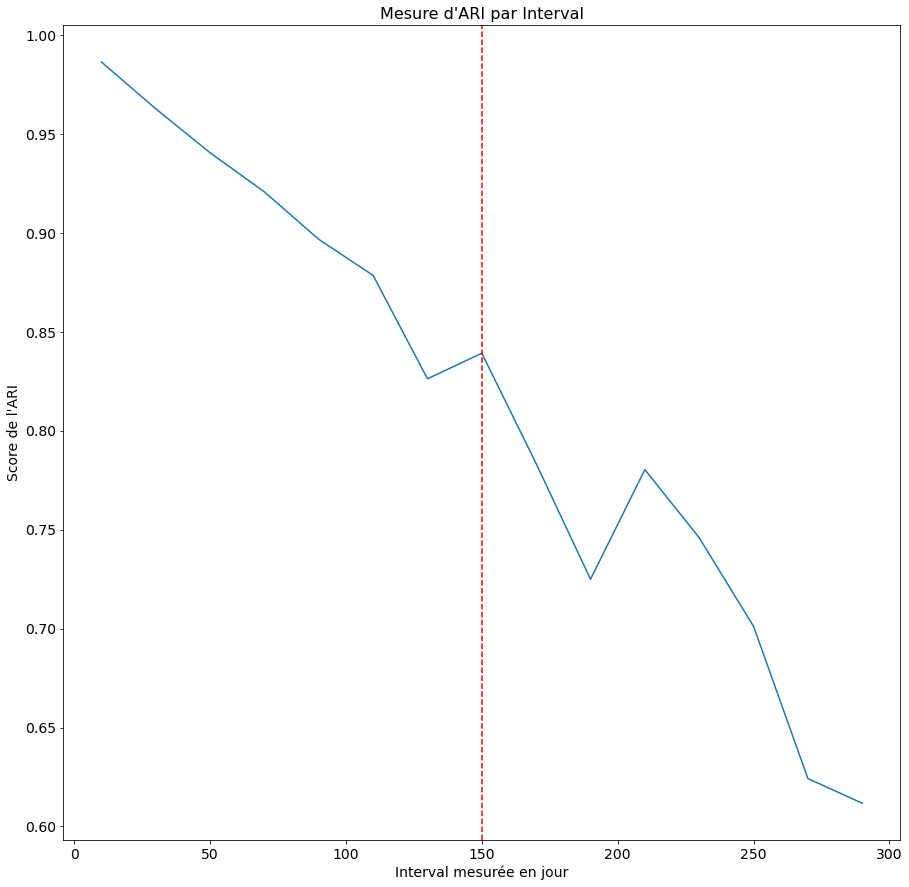

In [16]:
plt.figure(figsize=(15, 15))
df_step['mean'].plot()
plt.title('Mesure d\'ARI par Interval', fontsize=16)
plt.axvline(150, color="r", linestyle='--', label="La valeur choisi est : 150")
plt.xlabel("Interval mesurée en jour", fontsize=14)
plt.ylabel("Score de l'ARI", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40., 45.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

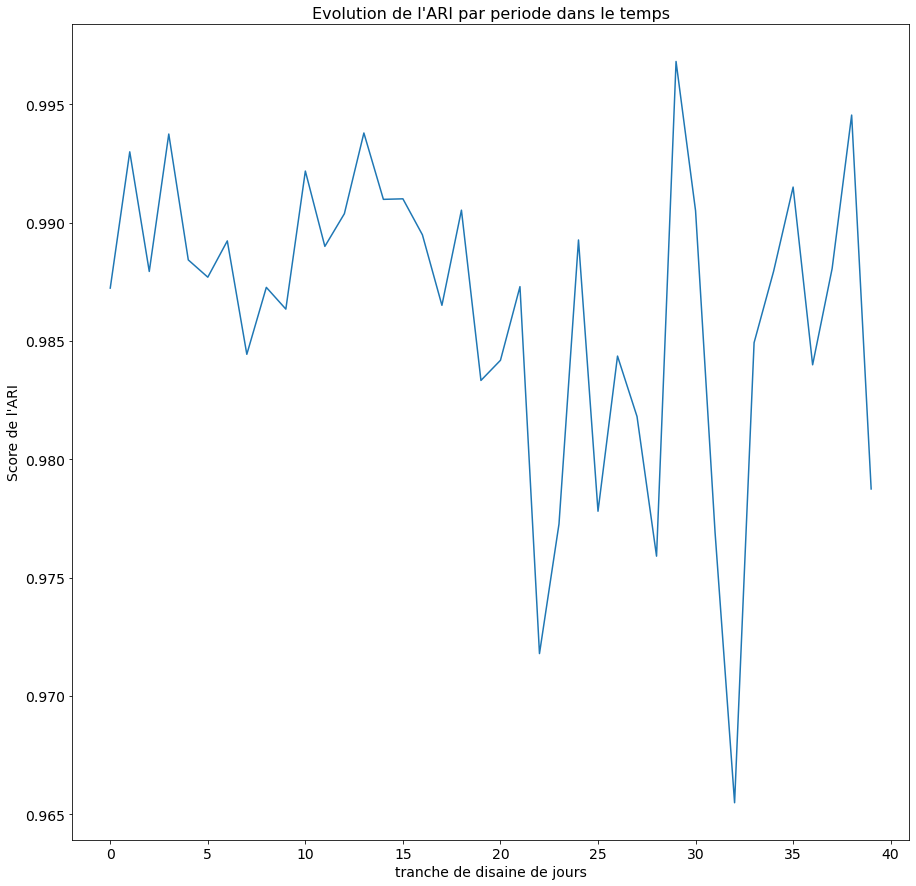

In [12]:
plt.figure(figsize=(15, 15))
plt.plot(df_step.loc[10, 'perf'])
plt.title('Evolution de l\'ARI par periode dans le temps', fontsize=16)
plt.xlabel("tranche de dizaine de jours", fontsize=14)
plt.ylabel("Score de l'ARI", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)